# Data loading

In [2]:
import pandas as pd
import numpy as npÒ
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


#Load Federal Funds Effective Rate (actual historical rates on the market, market tries to stick to targeted by Fed rates)
EFFR = pd.read_csv("data/FEDFUNDS.csv", sep=",")
#Load Federal Funds Futures (market expectations)
FFF = pd.read_csv("data/Federal_Fund_Future.csv", sep=";")


EFFR['observation_date'] = pd.to_datetime(EFFR['observation_date'])
FFF['Date'] = pd.to_datetime(FFF['Date'])
#we dont use these columns in our analysis
FFF = FFF.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], errors='ignore')
#calculate implicit fund rate from futures price : implicite_fund_rate price = 100 - price 
FFF['implicite_fund_rate'] = 100 - FFF['Price']

merged_df = pd.merge(
    FFF[['Date', 'implicite_fund_rate']], 
    EFFR[['observation_date', 'FEDFUNDS']], 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
)


# Load other  macro features
macro_df = pd.read_csv("data/macro_features_monthly.csv")
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'], dayfirst=True)
macro_df['DATE'] = macro_df['DATE'].values.astype('datetime64[M]')
merged_all = pd.merge(
    merged_df, 
    macro_df, 
    left_on='Date', 
    right_on='DATE', 
    how='inner'
)





# Feature creation

To build the features, we first look at the economic variables and recognize that most of them are non-stationary. Macroeconomic series such as GDP, CPI, unemployment, industrial production, financial stress indexes, and even market-implied rates typically have strong trends and persistent dynamics. Instead of running ADF tests on each variable, the straightforward way to handle this is to take first differences. Differencing removes long-run trends and isolates the month-to-month shocks that actually matter for monetary policy.

Once the variables are differenced, we create lags up to six months. This is important in finance because the Fed only has access to information up to t–1 when making a decision for period t, and economic effects usually propagate with delays. A six-month lag window is common in monetary policy work, as inflation shocks, employment changes, and financial stress measures tend to influence policy gradually rather than immediately.

We also include the implicit federal funds rate from Fed Funds Futures, because this reflects market expectations of future policy. Markets continuously price in new information, so the implied rate and its changes give the model forward-looking insight into how traders think the Fed will behave.

Finally, the target variable is whether the Federal Funds Rate increases at time t relative to t–1. In finance this corresponds to distinguishing a hawkish move from a dovish or neutral one. The model therefore learns to predict a rate hike at t based on economic conditions at t–1 and on how market expectations have evolved. We model hike or not hike (binary classification)

In [3]:


merged_all = merged_all.sort_values('Date').reset_index(drop=True)
df_features = merged_all.copy()
df_features['spread'] = df_features['implicite_fund_rate'] - df_features['FEDFUNDS']

#Calculate CHANGES (first differences) for stationarity
for el in ["spread","implicite_fund_rate",'CPIAUCSL', 'PCEPI', 'UNRATE', 'PAYEMS', 'GDP', 'INDPRO','FinStress']:
       df_features[f'{el}_change']=df_features[el].diff()
n_lags = 6  # Use past 6 months
#Lagged variables creation
for el in ["spread","implicite_fund_rate",'CPIAUCSL', 'PCEPI', 'UNRATE', 'PAYEMS', 'GDP', 'INDPRO','FinStress']:
    for i in range(1, n_lags + 1):
        df_features[f'{el}_change_lag_{i}'] = df_features[f'{el}_change'].shift(i)

df_features['future_fedfunds_change'] = df_features['FEDFUNDS'].diff()

# Binary classification: 1 if rate increases, 0 otherwise
df_features['target'] = (df_features['future_fedfunds_change'] > 0).astype(int)




We plot graphics to show the need of stationarizing series, also we see that even after it we have different scales, so we will use standartisation of variables in gradient based classification models 

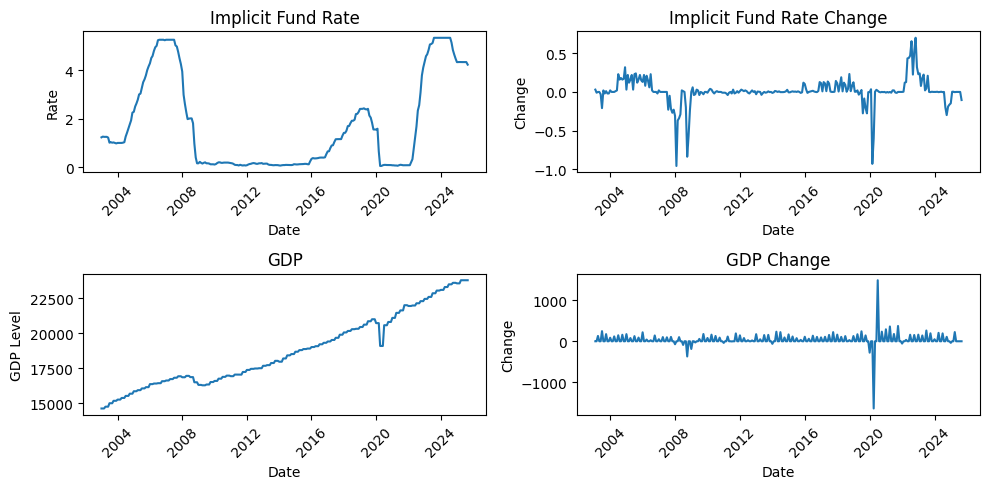

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# --- Top-left: Implicit Fund Rate ---
axes[0, 0].plot(df_features["Date"], df_features["implicite_fund_rate"])
axes[0, 0].set_title("Implicit Fund Rate")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Rate")
axes[0, 0].tick_params(axis='x', rotation=45)

# --- Top-right: Implicit Fund Rate Change ---
axes[0, 1].plot(df_features["Date"], df_features["implicite_fund_rate_change"])
axes[0, 1].set_title("Implicit Fund Rate Change")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Change")
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Bottom-left: GDP ---
axes[1, 0].plot(df_features["Date"], df_features["GDP"])
axes[1, 0].set_title("GDP")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("GDP Level")
axes[1, 0].tick_params(axis='x', rotation=45)

# --- Bottom-right: GDP Change ---
axes[1, 1].plot(df_features["Date"], df_features["GDP_change"])
axes[1, 1].set_title("GDP Change")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Change")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


We see that distribution of ones and zeros is quite balanced, so we can simplify a lot our analysis by looking only at accuracy score to determine best model 

In [5]:
df_final=df_features.dropna()
print("balanced dataset for accuracy : ",df_final['target'].value_counts())



balanced dataset for accuracy :  target
0    146
1    120
Name: count, dtype: int64


# Description of modelisation part

Now, we will create a special class that allows us to run multiples classifier experiments (mlflow) with hyperparameter optimisation (optuna), for the sake of simplicity and non-overfitting, we look at just two sets of models : Logisitc Regression and Random Forests, which will be both ran with different sets of hyperparameters, features to select the best experiment

Also, it will be naive to think that all created features will be usefull, so even after penalizations such as L1 (which selects variables), we will pre-select relevant variables with permutation method which measures how much model performance drops when a single feature is randomly shuffled. If shuffling a variable severely harms accuracy, the model truly depends on it; if accuracy barely changes, the variable is not informative. This method gives a more realistic picture of each feature’s contribution,so we will filter out all variables that result in less then 1%(also a hyperparameter) drop in accuracy.

### First models

For the initial model selection phase, we employed a straightforward train-test split approach, using 80% of the chronologically ordered data for training and reserving the final 20% for testing. 

The primary benefit of this approach was the ability to rapidly iterate through numerous experimental configurations without the computational burden of implementing full rolling window validations for each candidate model. This allowed for broader exploration of the model space, testing various algorithms, feature combinations, and hyperparameter settings that would have been prohibitively expensive to evaluate using more intensive validation schemes.

### Backtesting

After identifying the most promising model configuration through the initial screening process, we transitioned to a more rigorous validation methodology. The champion model was subjected to a proper rolling window (walk-forward) validation approach, which is considered the gold standard for time series prediction tasks.

This rolling window validation simulates the real-world application of the model more faithfully. It works by training on an initial segment of data (for example, the first 60% of observations), making a prediction for the next time step.

In [6]:
import pandas as pd
import mlflow
import optuna
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def check_params(allowed,kwargs):

    """ 
    validator function to test validity of arguments in kwargs
    """


    for key,val in kwargs.items():

                if key not in allowed:
                    raise ValueError(f"{key} unrecongized, use : {allowed.keys()}")
                if val not in allowed[key]:
                    raise ValueError(f"{val} unrecongized, for {key} use : {allowed[key]}")

class MlFlowModel:

    """
    class that allows to automate model building:

        exper_name : str -> unique name of experiment being used in mlflow and optuna
        kwargs : dict -> hyperparameters depending on models (penalties etc )
        model_instance : class -> class instance of owr model

    Be Aware that we support only Logistic regression and Random Forests here



    """

    def __init__(self,exper_name,model_instance,**kwargs):

        """
        supports two models: logistic regression and random forest only 

        """
        self.model_instance=model_instance
        self.exper_name=exper_name
        self.kwargs=kwargs
        self.n_trials=10

        if isinstance(self.model_instance,type):
            raise ValueError(f"dont forget parantheses in your model_instance")
        

        if self.model_instance.__class__ is not   LogisticRegression and  self.model_instance.__class__ is not RandomForestClassifier:
            raise ValueError('sorry, we can use logistic regression and random forest only for the moment ')


        if self.model_instance.__class__ is  LogisticRegression:
            allowed={
                "penalty" : ["l1", "l2", "elasticnet", None],
                "solver" : "saga"
            }

            if "penalty" not in kwargs.keys() or "solver" not in kwargs.keys():
                raise ValueError("need to specify both penalty and solver for logistic regression ")

        if self.model_instance.__class__ is  RandomForestClassifier:
            allowed={
                "max_features" : ["sqrt", "log2", None],
                "criterion" : ["gini", "entropy", "log_loss"]
            }
            if "max_features" not in kwargs.keys() or "criterion" not in kwargs.keys():
                raise ValueError("need to specify both max_features and criterion for randm forest ")

        
        check_params(allowed,self.kwargs)

    
    def objective(self,trial):

                """
                objective function of loss to minimize in our models using optuna package

                """
                

                if self.model_instance.__class__ is  LogisticRegression:

                    if "elasticnet" == self.kwargs["penalty"]:
                        # Define hyperparameter search space
                        params_candidate_space={
                            "l1_ratio": trial.suggest_float("l1_ratio", 0.1, 0.9),
                            "C":  trial.suggest_float("C", 0.1, 10),
                        }
                    elif "l1" == self.kwargs["penalty"] or "l2" == self.kwargs["penalty"]:
                        # Define hyperparameter search space
                        params_candidate_space={
                            "C":  trial.suggest_float("C", 0.1, 10),
                        }
                    
                if self.model_instance.__class__ is  RandomForestClassifier:

                    params_candidate_space={
                            'max_depth': trial.suggest_int("max_depth", 10, 50),
                            "min_samples_split":  trial.suggest_int("min_samples_split", 2, 10),
                            "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 4),
                 
                        }

                

                model = self.model_instance.__class__(
                    **params_candidate_space, 
                    **self.fixed_params,
                    **self.kwargs  
                )
            

                model.fit(self.X_train, self.y_train)


                #log_loss is sklearn is negative loglikelihood so we minimise it!!
                #in randomforest if we use gini, then we need to modify this line, but we do simple:
                score = log_loss(self.y_train, model.predict_proba(self.X_train))

                return score



    def run_optuna_study(self):

        """
        access optuna experiments
        """

        storage = f"sqlite:///optruns/optuna_{self.exper_name}.db"
        study = optuna.create_study(
                            direction="minimize", 
                            study_name=f"{self.exper_name}",
                            storage=storage,
                            load_if_exists=True
        )  # 'minimize' for loss functions
        study.optimize(self.objective, n_trials=self.n_trials)
        study_best_params=study.best_params
        return study_best_params

    def train(self,merged_df_,feature_columns):

        """ 
        main function of model training that brings together each steps

        """
        
        with mlflow.start_run(run_name=f"{self.exper_name}_FedFunds"):
        
                mlflow.log_param("model_type", self.model_instance.__class__.__name__)
                mlflow.log_param("variables", feature_columns)
                mlflow.log_param("scaler", "StandardScaler")
                mlflow.log_param("train_test_split", "80/20 time series")
                mlflow.log_param("kwargs",self.kwargs)
                
                #do easy splits and transforms:
                X = merged_df_[feature_columns]
                y = merged_df_['target']
                split_idx = int(len(merged_df_) * 0.8)
                self.X_train, self.X_test = X.iloc[:split_idx], X.iloc[split_idx:]
                self.y_train, self.y_test = y.iloc[:split_idx], y.iloc[split_idx:]
                #always standartise variables for logit 
                if self.model_instance.__class__ is  LogisticRegression:
                    scaler = StandardScaler()
                    self.X_train = scaler.fit_transform(self.X_train)
                    self.X_test = scaler.transform(self.X_test)

                # Model penalisations

                if self.model_instance.__class__ is  LogisticRegression:
                    print("normalising data")
                    self.fixed_params={
                        
                        "class_weight" : 'balanced',  
                        "random_state" : 42,
                    }
                

                    if self.kwargs["penalty"] is not None:
                        #in this case need to search space for best hyperparameter
                        study_best_params=self.run_optuna_study()
                        print("Best Hyperparameters:",study_best_params)
                    else:
                        study_best_params={}

                if self.model_instance.__class__ is  RandomForestClassifier:
                    self.fixed_params={
                        "n_estimators" : 150,
                        "class_weight" : 'balanced',  
                        "random_state" : 42,
                       
                    }
                    study_best_params=self.run_optuna_study()
                    print("Best Hyperparameters:",study_best_params)
                    

                        
                model = self.model_instance.__class__(
                     **self.fixed_params,
                     **study_best_params,
                     **self.kwargs                
                )
                print("-----------")
                

               
                model.fit(self.X_train, self.y_train)
                # Predictions
                y_pred = model.predict(self.X_test)
                
                acc = accuracy_score(self.y_test, y_pred)
                mlflow.log_metric("accuracy", acc)
                mlflow.sklearn.log_model(model, name="model")

                print(f"Run logged to MLflow: accuracy={acc:.4f}")


def var_selection_with_permutation(model,X,y,threshold_below_which_to_drop=0.01):

    '''
    simple function to filter out variables non informative, 
    non informative variables are those,who after permutation decrease a bit performance of the model
    supports any classification model, models implying gradient descent (parametric models) require dataset to be normalised 
    models such as random forests or other non gradient tree models do not require variable standartisation 
    '''
    
    split_idx = int(len(X) * 0.8)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    if model.__class__.__name__ in ["LogisticRegression",]:
        
        scaler = StandardScaler().set_output(transform="pandas")
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)



    model.fit(X_train, y_train)
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42,scoring="accuracy")

    perm_importances = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })
    
    return perm_importances[perm_importances["importance_mean"]>threshold_below_which_to_drop]["feature"].tolist()


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


runs model just on spreads (simplest model) to see the results

In [7]:
model = LogisticRegression(random_state=42, class_weight='balanced')
feature_columns =  [f'spread_change_lag_{i}' for i in range(1, n_lags + 1)] 
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("lrsimplest",LogisticRegression(),penalty=None,solver="saga")
model.train(df_final,feature_columns)

{'nb variables before permutation selection ': 6, 'nb variables after permutation selection ': 1}
normalising data
-----------


/opt/python/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/14 21:02:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.4815


the model is even worse then random guessing, so we will continue ..., for example now we will take all lagged variables (in difference)

In [8]:
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]


model=MlFlowModel("lr-all-vars",LogisticRegression(),penalty=None,solver="saga")
model.train(df_final,feature_columns)

normalising data
-----------


2025/11/14 21:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6852


better,let's try to use penalties

In [9]:
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]


model=MlFlowModel("lr-all-vars",LogisticRegression(),penalty="elasticnet",solver="saga")
model.train(df_final,feature_columns)

normalising data


[I 2025-11-14 21:02:14,243] A new study created in RDB with name: lr-all-vars
[I 2025-11-14 21:02:14,447] Trial 0 finished with value: 0.46663070448859884 and parameters: {'l1_ratio': 0.13479706166761263, 'C': 3.202380943865948}. Best is trial 0 with value: 0.46663070448859884.
[I 2025-11-14 21:02:14,769] Trial 1 finished with value: 0.4809519279221032 and parameters: {'l1_ratio': 0.5149539587074742, 'C': 0.7100322847756639}. Best is trial 0 with value: 0.46663070448859884.
[I 2025-11-14 21:02:14,911] Trial 2 finished with value: 0.46553162747669147 and parameters: {'l1_ratio': 0.3245254607280994, 'C': 8.241269791779255}. Best is trial 2 with value: 0.46553162747669147.
[I 2025-11-14 21:02:15,075] Trial 3 finished with value: 0.4670583729083164 and parameters: {'l1_ratio': 0.8406347765388422, 'C': 5.521431391700894}. Best is trial 2 with value: 0.46553162747669147.
[I 2025-11-14 21:02:15,232] Trial 4 finished with value: 0.46562503108884024 and parameters: {'l1_ratio': 0.21517152929930

Best Hyperparameters: {'l1_ratio': 0.11154939081588369, 'C': 9.068933361237182}
-----------


2025/11/14 21:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6852


let's filter 54 variables-> we get only 9 informative ones (as model penalisation)

In [10]:
model = LogisticRegression(random_state=42, class_weight='balanced')
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("lr-per-vars0.01-elnet",LogisticRegression(),penalty="elasticnet",solver="saga")
model.train(df_final,feature_columns_after_permutation_test)

{'nb variables before permutation selection ': 54, 'nb variables after permutation selection ': 9}
normalising data


[I 2025-11-14 21:02:22,893] A new study created in RDB with name: lr-per-vars0.01-elnet
[I 2025-11-14 21:02:23,051] Trial 0 finished with value: 0.5378736155583536 and parameters: {'l1_ratio': 0.4845744608940027, 'C': 1.010136244573784}. Best is trial 0 with value: 0.5378736155583536.
[I 2025-11-14 21:02:23,179] Trial 1 finished with value: 0.5588847757401316 and parameters: {'l1_ratio': 0.24438923943810942, 'C': 0.13070212626427485}. Best is trial 0 with value: 0.5378736155583536.
[I 2025-11-14 21:02:23,305] Trial 2 finished with value: 0.536364693809738 and parameters: {'l1_ratio': 0.26619160415069265, 'C': 6.06532391074197}. Best is trial 2 with value: 0.536364693809738.
[I 2025-11-14 21:02:23,429] Trial 3 finished with value: 0.5364955780307757 and parameters: {'l1_ratio': 0.33442681059191315, 'C': 3.6694018985059005}. Best is trial 2 with value: 0.536364693809738.
[I 2025-11-14 21:02:23,531] Trial 4 finished with value: 0.536739125769604 and parameters: {'l1_ratio': 0.542582156214

Best Hyperparameters: {'l1_ratio': 0.8347526965091933, 'C': 8.69532885091907}
-----------


2025/11/14 21:02:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.6667


try random forests

In [11]:
model = LogisticRegression( random_state=42,class_weight='balanced')
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y,0.02)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("rf-per-vars0.02-sqrt-logloss",RandomForestClassifier(),max_features="sqrt",criterion="log_loss")
model.train(df_final,feature_columns_after_permutation_test)

{'nb variables before permutation selection ': 54, 'nb variables after permutation selection ': 7}


[I 2025-11-14 21:02:30,110] A new study created in RDB with name: rf-per-vars0.02-sqrt-logloss
[I 2025-11-14 21:02:30,459] Trial 0 finished with value: 0.3172640467265919 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3172640467265919.
[I 2025-11-14 21:02:30,798] Trial 1 finished with value: 0.2419900474233764 and parameters: {'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.2419900474233764.
[I 2025-11-14 21:02:31,119] Trial 2 finished with value: 0.2772191459899057 and parameters: {'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.2419900474233764.
[I 2025-11-14 21:02:31,451] Trial 3 finished with value: 0.23078677349647833 and parameters: {'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.23078677349647833.
[I 2025-11-14 21:02:31,775] Trial 4 finished with value: 0.2622506082541955 and

Best Hyperparameters: {'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}
-----------


2025/11/14 21:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.9074


results significantly increased, indicating non linear relationship in models

In [12]:
model = LogisticRegression( random_state=42,class_weight='balanced')
feature_columns=[col for col in df_final.columns if 'change' in col.lower()  and col[-1].isdigit() ]
X = df_final[feature_columns]
y = df_final['target']
feature_columns_after_permutation_test=var_selection_with_permutation(model,X,y,0.01)
print(
{
    "nb variables before permutation selection " : len(feature_columns),
    "nb variables after permutation selection " : len(feature_columns_after_permutation_test)

}
)
model=MlFlowModel("rf-per-vars0.01-sqrt-gini",RandomForestClassifier(),max_features="sqrt",criterion="gini")
model.train(df_final,feature_columns_after_permutation_test)

{'nb variables before permutation selection ': 54, 'nb variables after permutation selection ': 9}


[I 2025-11-14 21:02:37,967] A new study created in RDB with name: rf-per-vars0.01-sqrt-gini
[I 2025-11-14 21:02:38,329] Trial 0 finished with value: 0.29017860978948495 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.29017860978948495.
[I 2025-11-14 21:02:38,964] Trial 1 finished with value: 0.2832191017594631 and parameters: {'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.2832191017594631.
[I 2025-11-14 21:02:39,349] Trial 2 finished with value: 0.22725023616219503 and parameters: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.22725023616219503.
[I 2025-11-14 21:02:39,706] Trial 3 finished with value: 0.2914842840866053 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.22725023616219503.
[I 2025-11-14 21:02:40,046] Trial 4 finished with value: 0.33522217808352095 an

Best Hyperparameters: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 1}
-----------


2025/11/14 21:02:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow: accuracy=0.8889


we visualise all past experiments to get the best model with corresponding hyperparameters and features 

In [13]:


import mlflow 
experiments = mlflow.search_experiments()
runs=mlflow.search_runs(experiment_ids=[exp.experiment_id for exp in experiments])
best=runs.sort_values("metrics.accuracy",ascending=False)[["status","run_id","metrics.accuracy","params.model_type","params.variables","params.kwargs","tags.mlflow.runName"]].reset_index(drop=True)
champion_model_id=best["run_id"][0]
champion_model_variables=ast.literal_eval(best["params.variables"][0])
champion_model_kwargs=ast.literal_eval(best["params.kwargs"][0])
champion_model_name=best["tags.mlflow.runName"][0]
champion_model_name = champion_model_name.replace('FedFunds', '')
champion_model_name= champion_model_name.replace('_', '')
best.head()

,status,run_id,metrics.accuracy,params.model_type,params.variables,params.kwargs,tags.mlflow.runName
0,FINISHED,7ac7fe0e671f4cba893373f0f8d04a5c,0.907407,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'log_loss'}",rf-per-vars0.02-sqrt-logloss_FedFunds
1,FINISHED,36b466f256f54abda1df56573818848f,0.907407,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'gini'}",rf-per-vars0.01-sqrt-gini_FedFunds
2,FINISHED,dba5b13ced6f4fdb90ba062bdb51b27c,0.888889,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'log_loss'}",rf-per-vars0.02-sqrt-logloss_FedFunds
3,FINISHED,8937c43c30264356be4fbcc60a72f73a,0.888889,RandomForestClassifier,"['implicite_fund_rate_change_lag_1', 'implicit...","{'max_features': 'sqrt', 'criterion': 'gini'}",rf-per-vars0.01-sqrt-gini_FedFunds
4,FINISHED,21eaeb8894cc453ba699cc5ad6be77e1,0.685185,LogisticRegression,"['spread_change_lag_1', 'spread_change_lag_2',...","{'penalty': None, 'solver': 'saga'}",lr-all-vars_FedFunds


access best hyperparameters of champion model 

In [14]:
storage=f"sqlite:///optruns/optuna_{champion_model_name}.db"
study = optuna.load_study(
    study_name=champion_model_name,
    storage=storage 
)

print("Best params:", study.best_params)


Best params: {'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}


load this model and use it for validation and backtesting

In [15]:
champion_model=mlflow.pyfunc.load_model(f"runs:/{champion_model_id}/model")
champion_model_variables

['implicite_fund_rate_change_lag_1',
 'implicite_fund_rate_change_lag_2',
 'implicite_fund_rate_change_lag_3',
 'PCEPI_change_lag_1',
 'PCEPI_change_lag_6',
 'GDP_change_lag_1',
 'INDPRO_change_lag_1']

Now, once we have the best model we can do model validation and visualisation of results, as well as do rolling model 

In [16]:
X = df_final[champion_model_variables]
y = df_final['target']
split_idx = int(len(df_final) * 0.8)
X_train,X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Predictions
y_pred = champion_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9074074074074074

so if we use non temporal approach, then we get 90% accuracy

In [17]:

import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    construct matrix of errors (confusion)
    cm - matrix of errors 
    classes - list of classes
    normalize - if True then normalised to 1
    title - title
    cmap - colors
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


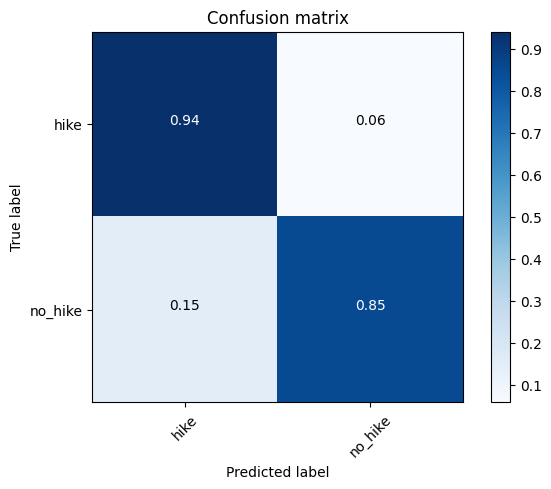

In [18]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,["hike","no_hike"],normalize=True)

Now, let's assume that we found the best model  like this also for the rolling windows approach to back test dynamically on each day prediction: 

In [19]:

X = df_final[champion_model_variables].values
y = df_final['target'].values

n = len(df_final)

#Starting point for first train window (for example we take 60%)
start_idx = int(n * 0.60)
predictions = []
actuals = []
accuracies=[]
for t in range(start_idx, n - 1):

    # Training set = from 0 to t
    X_train = X[:t]          
    y_train = y[:t]

    # Test point = next step (t+1)
    X_test = X[t].reshape(1, -1)
    y_test = y[t]

    # Train model
    model = RandomForestClassifier(
        n_estimators=150,
     
        random_state=42,
        **study.best_params,
        class_weight ='balanced'
    )
    model.fit(X_train, y_train)

    # Predict t+1
    pred = model.predict(X_test)[0]

    predictions.append(pred)
    
    actuals.append(y_test)
    accuracies.append(accuracy_score(actuals, predictions))

# Final rolling accuracy
rolling_accuracy = accuracy_score(actuals, predictions)
print("Rolling Forecast Accuracy:", rolling_accuracy)


Rolling Forecast Accuracy: 0.7830188679245284


we see that final rolling accuracy is of 80% which is good for rolling window approach 

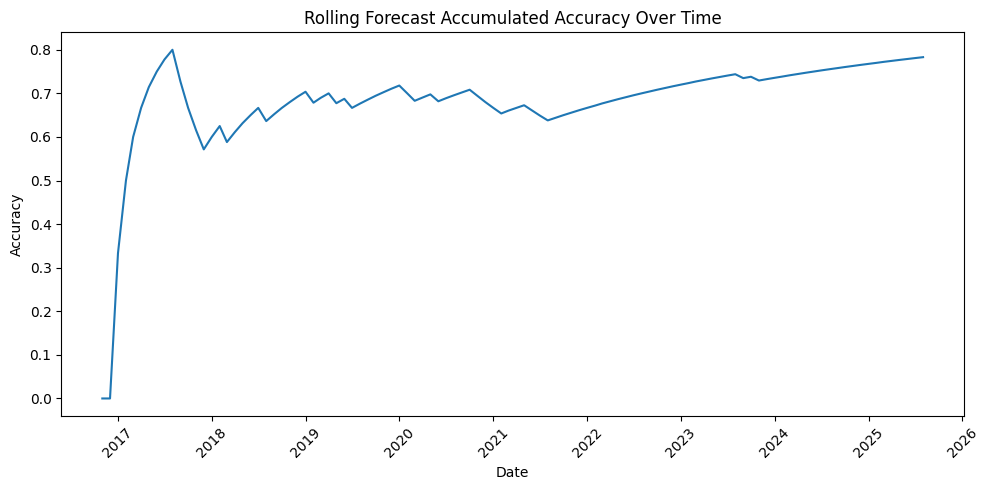

In [20]:
accuracy_dates = df_final['Date'][start_idx : n-1].reset_index(drop=True)
plt.figure(figsize=(10,5))
plt.plot(accuracy_dates, accuracies)
plt.title("Rolling Forecast Accumulated Accuracy Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#this graphic is not very interesting as it is like accumulated accuracy, but still we see fast convergence to 80% 

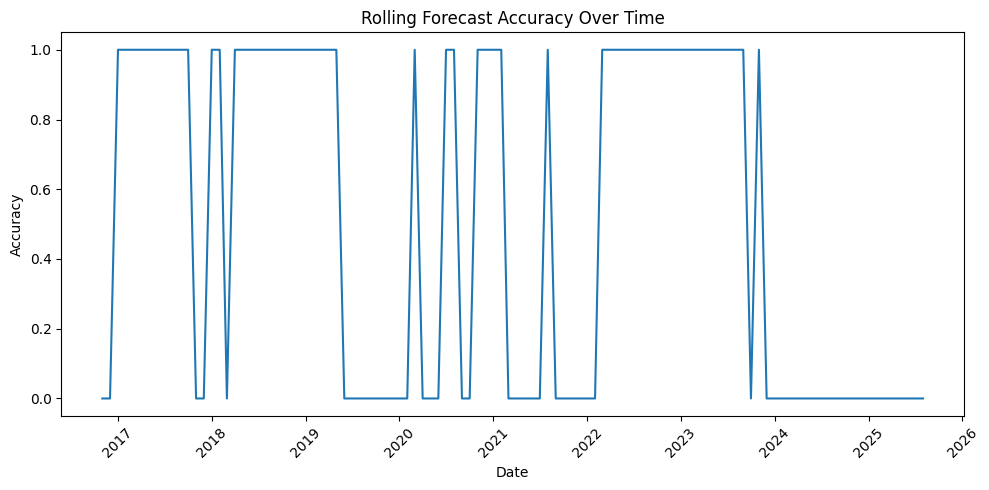

In [21]:

plt.figure(figsize=(10,5))
plt.plot(accuracy_dates, predictions)
plt.title("Rolling Forecast Accuracy Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

accuracy for each day is measured 0 or 1 simply, we see that the model behaves very well for all months between 2022 and 2024(latest data when train period is from 2000), however, there were lot of instability between 2019 and 2021 which can be related also to covid-19.

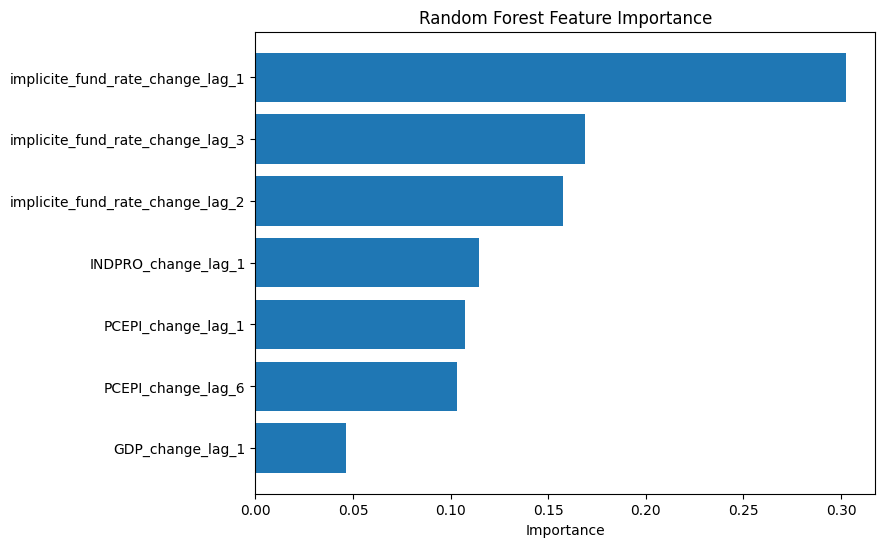

In [22]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': champion_model_variables,
    'importance': importances
}).sort_values('importance', ascending=False)


plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

Finally what is interesting is to understand what features are the most important for our classification , clearly the most important aee implicit fund rate short term memory up to lag 3 , personal consumtion expenditures and industrial production index. These importances are calculated during training of random forests. for each decision tree at each split generated by certain variable we measure decrease in entropy , then we simply average these decreasings for every variable, the highest decreasings are highest importances.